# Intuit QuickBooks Upgrade: Modeling response to an up-selling campaign

## Goal: 

Intuit is launching a version 3 upgrade for its accounting software Quickbooks. Customers who bought the upgrade from Intuit Direct (i.e. delivery through mail) was the response for the model. Goal is to maximize profit by targeting those customers most likely to purchase the upgrade and save on mailing costs from not having to mail those customers who are not likely to buy.

In [1]:
from IPython.display import HTML

HTML('''

<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()">
  <input type="submit" id="toggleButton" value="Show Python 3 Code">
</form>''')

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neural_network import MLPClassifier

from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from sklearn.inspection import permutation_importance, plot_partial_dependence

# increase plot resolution
mpl.rcParams["figure.dpi"] = 80

## The Data

(courtesy Vincent Nijs - Rady School of Management - University of California San Diego, Phillip Pfeifer - University of Virginia - Darden)

- 801821 customers were mailed the offer in wave-1 , out of which 38,487 responded.
- 801821 people are those who have bought atleast one quickbooks version (i.e. ver 1 or ver 2)
- 75000 customers randomly sampled from the 801821 are available 
- Cost of mailing the offer to a single customer is \\$1.41, margin to Intuit from the a single purchase is \\$60
- Demographic variables available: zip code binned into 20 groups (zip_bins), gender (sex), was the customer a business? (bizflag)
- Purchasing indicators from Intuit Direct: Days since last purchase (last), frequency of purchase (numords), spend \$ on purchases (dollars), days since original purchase of Quickbooks (Ver 1 or 2) (sincepurch)
- Indicators of desirable behavior: Did customer own a previous tax product (owntaxprod)?, Did customer upgrade from Ver 1 to ver 2? (upgraded)
- Response: Res1: Did customer respond to wave-1 mailing?

In [3]:
# Data from relative path:
intuit75k = pd.read_pickle("data/intuit75k.pkl")
# rsm.describe(intuit75k)
intuit75k.head(10)

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0
5,6,12309,3,Male,0,1,20.0,17,17,0,0,1,No,1
6,7,22980,5,Male,0,1,49.5,13,36,1,0,0,No,0
7,8,55122,11,Male,1,1,24.5,4,17,1,0,0,No,1
8,9,34950,8,Male,0,1,44.5,15,4,0,0,0,No,0
9,10,20036,5,Male,0,3,73.5,10,9,0,0,0,No,1


# Methodology

- Data exploration on features, which ones to include, which ones are non-linear and could they be grouped?
- Modeling using Logistic regression and Neural network to predict wave-1 data and compare to actual wave_1 results to validate models (30% / 22500 test samples)
- Pick model with highest profit (not highest AUC, because even if AUC is higher for a model, at the concerned threshold/breakeven prediction point, profit may be lower)
- Calculate expected profit from wave-2 mailing to the remainder customers (i.e. customer who DID NOT buy from wave-1 mailing) factoring in the industry expectation that response would be 50% lower since the same customers are seeing the mailer for a second time

# Value to stakeholder

\\$ 443421 is the expected profit from the remainder 763334 customers by using a modeling aided targeting approach for the wave2_mailer <br>
\\$ 46309 is the expected profit from no_targeting

In [4]:
# converting data types
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype("int")

intuit75k[["zip", "zip_bins", "sex"]] = intuit75k[["zip", "zip_bins", "sex"]].astype("category")

intuit75k["bizflag"] = intuit75k["bizflag"].astype("category")
intuit75k.loc[:, "version1":"upgraded"] = intuit75k.loc[:, "version1":"upgraded"].astype("category")

# Exploratory Data Analysis (EDA)

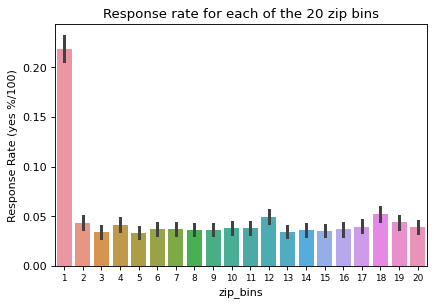

In [5]:
plot1 = sns.barplot(data = intuit75k, x = 'zip_bins', y = 'res1_yes')
plot1.set(ylabel="Response Rate (yes %/100)")
plot1.set(title="Response rate for each of the 20 zip bins")
for item in (plot1.get_xticklabels()):
    item.set_fontsize(8)

In [6]:
print("Zip codes with highest number of buying customers in zip bin 1: ")
intuit75k.query("zip_bins == 1 and res1_yes == 1")['zip'].value_counts()

Zip codes with highest number of buying customers in zip bin 1: 


00801    688
00804     64
00000      5
01923      4
01890      3
        ... 
33016      0
33015      0
33014      0
33012      0
99999      0
Name: zip, Length: 7079, dtype: int64

Further evaluation revealed zip codes 00801 and 804 were in the US Virgin islands, possibly customers who preferred to have the latest quickbook products and the reliance on Intuit Direct (mailers) in the absence of brick and mortar retail stores. These two zip codes would be binned separately.

In [7]:
intuit75k = intuit75k.assign(zip_801_yes = rsm.ifelse(intuit75k.zip == "00801", 1, 0))
intuit75k['zip_801_yes'] = intuit75k['zip_801_yes'].astype('category')

intuit75k = intuit75k.assign(zip_804_yes = rsm.ifelse(intuit75k.zip == "00804", 1, 0))
intuit75k['zip_804_yes'] = intuit75k['zip_804_yes'].astype('category')

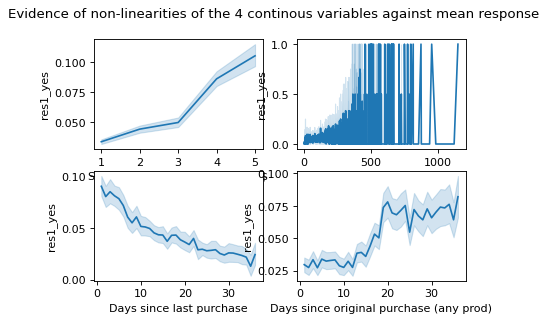

In [8]:
fig, axs = plt.subplots(ncols=2, nrows = 2)

sns.lineplot(data = intuit75k, x = 'numords', y = 'res1_yes', estimator = 'mean', ax=axs[0, 0])
axs[0, 0].set_xlabel("Number of orders per customer")

sns.lineplot(data = intuit75k, x = 'dollars', y = 'res1_yes', estimator = 'mean', ax=axs[0, 1])
axs[0, 0].set_xlabel("Spend on orders per customer $")

sns.lineplot(data = intuit75k, x = 'last', y = 'res1_yes', estimator = 'mean', ax=axs[1, 0])
axs[1, 0].set_xlabel("Days since last purchase")

sns.lineplot(data = intuit75k, x = 'sincepurch', y = 'res1_yes', estimator = 'mean', ax=axs[1, 1])
axs[1, 1].set_xlabel("Days since original purchase (any prod)")

fig.suptitle('Evidence of non-linearities of the 4 continous variables against mean response')

plt.show()

In [9]:
# Grouping continuous variables into bins to capture non-linearities
print("Max number of orders per customer", np.max(intuit75k.numords))
bins=[0, 3, 4, 5]
labels=['n1', 'n2', 'n3']
intuit75k['numords_bins']=pd.cut(intuit75k['numords'], bins=bins,labels=labels)
#intuit75k[['numords_bins', 'numords']].value_counts()

print("Largest number of days since original purchase (any prod)", np.max(intuit75k.sincepurch))
bins=[0, 10, 15, 20, 36]
labels=['s1', 's2', 's3', 's4']
intuit75k['sincepurch_bins']=pd.cut(intuit75k['sincepurch'], bins=bins,labels=labels)
#intuit75k[['sincepurch_bins', 'sincepurch']].value_counts()

print("Largest number of days since last purchase", np.max(intuit75k['last']))
bins=[0, 10, 20, 30, 40]
labels=['l1', 'l2', 'l3', 'l4']
intuit75k['last_bins']=pd.cut(intuit75k['last'], bins=bins,labels=labels)
#intuit75k[['last_bins', 'last']].value_counts()

print("Largest order spend $", np.max(intuit75k['dollars']))
bins=[0,100,200,300,400,500,600,700,800,900,1200]
labels=['d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']
intuit75k['dollars_bins']=pd.cut(intuit75k['dollars'], bins=bins,labels=labels)
#intuit75k[['dollars_bins', 'dollars']].value_counts()

Max number of orders per customer 5
Largest number of days since original purchase (any prod) 36
Largest number of days since last purchase 36
Largest order spend $ 1149.0


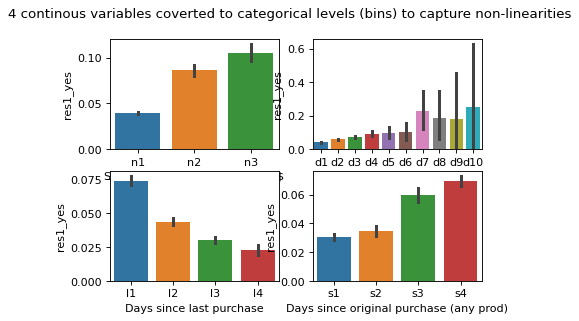

In [10]:
fig, axs = plt.subplots(ncols=2, nrows = 2)

sns.barplot(data = intuit75k, x = 'numords_bins', y = 'res1_yes', ax=axs[0, 0])
axs[0, 0].set_xlabel("Number of orders per customer")

sns.barplot(data = intuit75k, x = 'dollars_bins', y = 'res1_yes', ax=axs[0, 1])
axs[0, 0].set_xlabel("Spend on orders per customer $")

sns.barplot(data = intuit75k, x = 'last_bins', y = 'res1_yes', ax=axs[1, 0])
axs[1, 0].set_xlabel("Days since last purchase")

sns.barplot(data = intuit75k, x = 'sincepurch_bins', y = 'res1_yes', ax=axs[1, 1])
axs[1, 1].set_xlabel("Days since original purchase (any prod)")

fig.suptitle('4 continous variables coverted to categorical levels (bins) to capture non-linearities')

plt.show()

#rsm.prop_plot(bbb[train], "mon_iq", "buyer", "yes")

In [11]:
intuit75k.dtypes

id                    int32
zip                category
zip_bins           category
sex                category
bizflag            category
numords               int32
dollars             float64
last                  int32
sincepurch            int32
version1           category
owntaxprod         category
upgraded           category
res1               category
training              int32
res1_yes              int64
zip_801_yes        category
zip_804_yes        category
numords_bins       category
sincepurch_bins    category
last_bins          category
dollars_bins       category
dtype: object

In [12]:
intuit75k

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,upgraded,res1,training,res1_yes,zip_801_yes,zip_804_yes,numords_bins,sincepurch_bins,last_bins,dollars_bins
0,1,94553,18,Male,0,2,109.5,5,12,0,...,0,No,1,0,0,0,n1,s2,l1,d2
1,2,53190,10,Unknown,0,1,69.5,4,3,0,...,0,No,0,0,0,0,n1,s1,l1,d1
2,3,37091,8,Male,0,4,93.0,14,29,0,...,1,No,0,0,0,0,n2,s4,l2,d1
3,4,02125,1,Male,0,1,22.0,17,1,0,...,0,No,1,0,0,0,n1,s1,l2,d1
4,5,60201,11,Male,0,1,24.5,2,3,0,...,0,No,0,0,0,0,n1,s1,l1,d1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,74996,28205,6,Male,1,4,211.5,5,15,0,...,0,Yes,1,1,0,0,n2,s2,l1,d3
74996,74997,94806,18,Male,0,1,4.5,35,34,1,...,0,No,1,0,0,0,n1,s4,l4,d1
74997,74998,72958,13,Female,1,1,54.5,4,19,1,...,0,No,1,0,0,0,n1,s3,l1,d1
74998,74999,29464,6,Male,0,1,69.5,20,27,0,...,1,No,1,0,0,0,n1,s4,l2,d1


In [42]:
# setting up variables to track column names as needed
rvar = "res1_yes"
evar_binaries = intuit75k[["bizflag", "version1", "owntaxprod", "upgraded", "zip_801_yes", "zip_804_yes"]]
evar_dummies = pd.get_dummies(intuit75k[["sex","numords_bins", "sincepurch_bins", "last_bins", "dollars_bins"]], drop_first=True)
evar = pd.concat([evar_binaries, evar_dummies], axis = 1)

idvar = "id"
lev = 1

training = intuit75k.training

evar.columns

Index(['bizflag', 'version1', 'owntaxprod', 'upgraded', 'zip_801_yes',
       'zip_804_yes', 'sex_Male', 'sex_Unknown', 'numords_bins_n2',
       'numords_bins_n3', 'sincepurch_bins_s2', 'sincepurch_bins_s3',
       'sincepurch_bins_s4', 'last_bins_l2', 'last_bins_l3', 'last_bins_l4',
       'dollars_bins_d2', 'dollars_bins_d3', 'dollars_bins_d4',
       'dollars_bins_d5', 'dollars_bins_d6', 'dollars_bins_d7',
       'dollars_bins_d8', 'dollars_bins_d9', 'dollars_bins_d10'],
      dtype='object')

### No scaling required, as all features are categorical variables (and one-hot encoded dummies for NN) 

In [14]:
lr_evar = pd.concat([evar_binaries, intuit75k[["zip_bins", "sex", "numords_bins", "sincepurch_bins", "last_bins", "dollars_bins"]]], axis = 1)
lr_evar

,bizflag,version1,owntaxprod,upgraded,zip_801_yes,zip_804_yes,zip_bins,sex,numords_bins,sincepurch_bins,last_bins,dollars_bins
0,0,0,0,0,0,0,18,Male,n1,s2,l1,d2
1,0,0,0,0,0,0,10,Unknown,n1,s1,l1,d1
2,0,0,0,1,0,0,8,Male,n2,s4,l2,d1
3,0,0,0,0,0,0,1,Male,n1,s1,l2,d1
4,0,0,0,0,0,0,11,Male,n1,s1,l1,d1
...,...,...,...,...,...,...,...,...,...,...,...,...
74995,1,0,0,0,0,0,6,Male,n2,s2,l1,d3
74996,0,1,0,0,0,0,18,Male,n1,s4,l4,d1
74997,1,1,0,0,0,0,13,Female,n1,s3,l1,d1
74998,0,0,0,1,0,0,6,Male,n1,s4,l2,d1


## Logistic Model (GLM) - without interaction effects

In [15]:
lr = "res1_yes ~ " + " + ".join(lr_evar)

lr_model = smf.glm(
    formula= lr,
    family=Binomial(link=logit()),
    data=intuit75k.query('training == 1')
)

# Check for multicollinearity / variance inflation factor
#rsm.vif(lr_model)

In [62]:
lr_model = smf.glm(
    formula= lr,
    family=Binomial(link=logit()),
    data=intuit75k.query('training == 1')
).fit()

#lr_model.summary()

eval_dat = pd.DataFrame()
eval_dat['res1_yes'] = intuit75k.res1_yes
eval_dat = eval_dat.assign(y_lr = lr_model.predict(lr_evar))
eval_dat["training"] = intuit75k.training

rsm.model_fit(lr_model)


Pseudo R-squared (McFadden): 0.156
Pseudo R-squared (McFadden adjusted): 0.152
Log-likelihood: -8473.468, AIC: 17046.937, BIC: 17490.365
Chi-squared: 50691.339 df(49), p.value < 0.001 
Nr obs: 52,500



In [17]:
rsm.or_ci(lr_model, importance=True).sort_values("importance", ascending=False)

,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance
5,zip_801_yes[T.1],25.232,2423.2%,18.303,34.784,< .001,***,True,25.232
6,zip_804_yes[T.1],17.893,1689.3%,10.997,29.112,< .001,***,True,17.893
43,dollars_bins[T.d9],7.865,686.5%,1.361,45.451,0.021,*,True,7.865
42,dollars_bins[T.d8],6.185,518.5%,2.128,17.978,< .001,***,True,6.185
35,last_bins[T.l4],0.280,-72.0%,0.225,0.348,< .001,***,True,3.576
4,upgraded[T.1],2.888,188.8%,2.254,3.702,< .001,***,True,2.888
41,dollars_bins[T.d7],2.831,183.1%,1.084,7.398,0.034,*,True,2.831
44,dollars_bins[T.d10],2.767,176.7%,0.267,28.658,0.394,,True,2.767
34,last_bins[T.l3],0.393,-60.7%,0.348,0.445,< .001,***,True,2.543
29,numords_bins[T.n3],2.488,148.8%,2.151,2.878,< .001,***,True,2.488


<AxesSubplot:xlabel='Odds-ratio'>

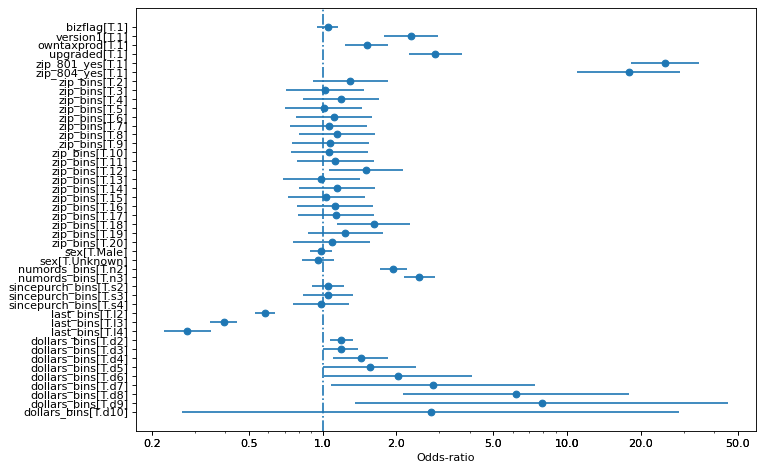

In [18]:
rsm.or_plot(lr_model, figsize=(10,7))

#### To verify if keeing zip_bins was signficant to model with having zip_801 and zip_804 present in the model, low p-Value from wald test suggests zip_bins is significant:

In [19]:
lr_model.wald_test_terms().table.round(3)

,statistic,pvalue,df_constraint
Intercept,502.682,0.000,1
bizflag,0.905,0.342,1
version1,42.546,0.000,1
owntaxprod,15.694,0.000,1
upgraded,70.169,0.000,1
zip_801_yes,388.404,0.000,1
zip_804_yes,134.899,0.000,1
zip_bins,33.348,0.022,19
sex,0.263,0.877,2
numords_bins,191.889,0.000,2


## Interactions observed:
    
A customer who buys frequently (high number of orders) and who uses version1 is highly likely to take the upgrade offer. See the increase in difference between the interacted model and the model without interaction.

[Text(0.5, 1.0, 'Predicted Response Rate (%/100) when Number of orders and Version1 are not interacted')]

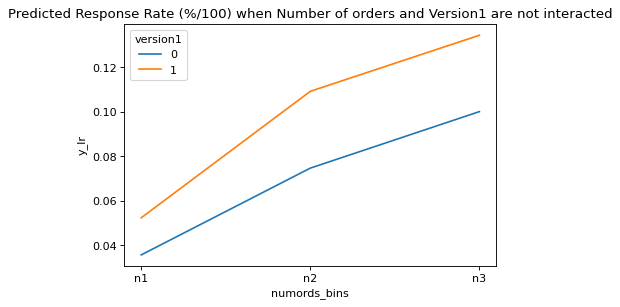

In [21]:
fig = sns.lineplot(x = intuit75k.numords_bins, y = eval_dat.y_lr, hue = intuit75k.version1, ci = None)
fig.set(title = "Predicted Response Rate (%/100) when Number of orders and Version1 are not interacted")

[Text(0.5, 1.0, 'Predicted Response Rate (%/100) when Number of orders and Version1 are Interacted')]

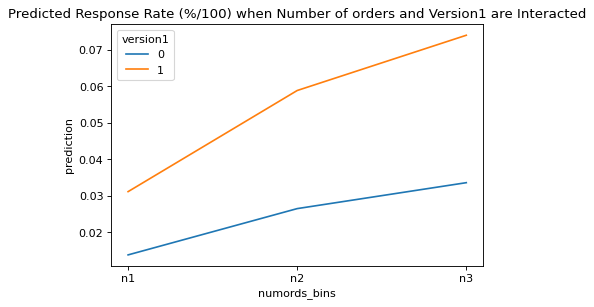

In [22]:
idat = rsm.sim_prediction(lr_evar, vary=["numords_bins", "version1"])
idat["prediction"] = lr_model.predict(idat)
fig = sns.lineplot(x="numords_bins", y="prediction", hue="version1", data=idat)
fig.set(title = "Predicted Response Rate (%/100) when Number of orders and Version1 are Interacted")

A customer who bought recently (few number of days since last order) and who uses version1 is highly likely to take the upgrade offer. See the increase in difference between the interacted model and the model without interaction.

[Text(0.5, 1.0, 'Predicted Response Rate (%/100) when Days since last order and Version1 are not interacted')]

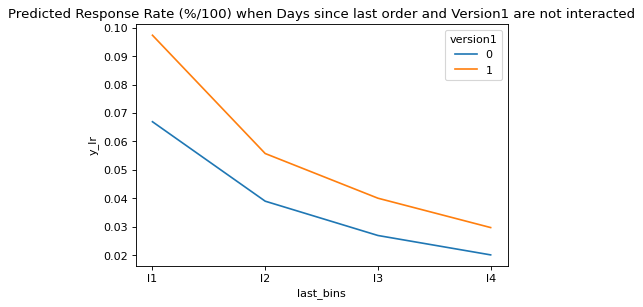

In [23]:
fig = sns.lineplot(x = intuit75k.last_bins, y = eval_dat.y_lr, hue = intuit75k.version1, ci = None)
fig.set(title = "Predicted Response Rate (%/100) when Days since last order and Version1 are not interacted")

[Text(0.5, 1.0, 'Predicted Response Rate (%/100) when Days since last order and Version1 are Interacted')]

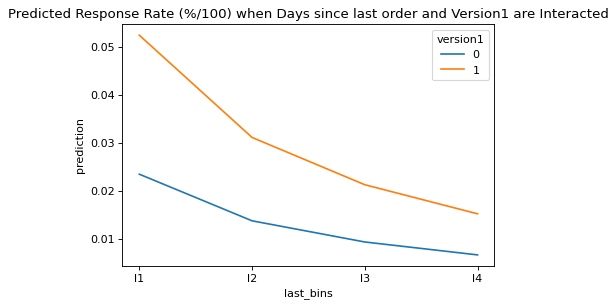

In [24]:
idat = rsm.sim_prediction(lr_evar, vary=["last_bins", "version1"])
idat["prediction"] = lr_model.predict(idat)
fig = sns.lineplot(x="last_bins", y="prediction", hue="version1", data=idat)
fig.set(title = "Predicted Response Rate (%/100) when Days since last order and Version1 are Interacted")

## Logistic Model (GLM) - with interaction effects

In [74]:
lr = "res1_yes ~ " + " + ".join(lr_evar) + " + numords_bins:version1 + last_bins:version1" 

lr_model = smf.glm(
    formula= lr,
    family=Binomial(link=logit()),
    data=intuit75k.query('training == 1')
).fit()

#lr_model.summary()

eval_dat = eval_dat.assign(y_lr_int = lr_model.predict(lr_evar))

rsm.model_fit(lr_model)


Pseudo R-squared (McFadden): 0.156
Pseudo R-squared (McFadden adjusted): 0.152
Log-likelihood: -8473.468, AIC: 17046.937, BIC: 17490.365
Chi-squared: 50691.339 df(49), p.value < 0.001 
Nr obs: 52,500



,res1_yes,y_lr,training,y_nn_cv,y_lr_int
0,0,0.046242,1,0.031552,0.046242
1,0,0.024574,0,0.024393,0.024574
2,0,0.066993,0,0.066968,0.066993
3,0,0.016606,1,0.017761,0.016606
4,0,0.026523,0,0.026036,0.026523
...,...,...,...,...,...
74995,1,0.046024,1,0.052747,0.046024
74996,0,0.013850,1,0.009653,0.013850
74997,0,0.056142,1,0.061877,0.056142
74998,0,0.050032,1,0.054064,0.050032


## Neural Networks - with cross validated hyper parameter tuning

In [43]:
clf = MLPClassifier(
    activation="tanh",
    solver="lbfgs",
    alpha=0.01,
    hidden_layer_sizes=(1,),
    random_state=1234,
    max_iter=10000,
).fit(evar[training == 1], intuit75k[training == 1][rvar])

In [44]:
nr_hnodes = range(1, 8)
hls = list(zip(nr_hnodes)) + list(zip(nr_hnodes, nr_hnodes))
hls

[(1,),
 (2,),
 (3,),
 (4,),
 (5,),
 (6,),
 (7,),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7)]

In [46]:
param_grid = {
    'hidden_layer_sizes': hls,
    'alpha': [0.0005, 0.0075, 0.001, 0.002, 0.003, 0.005, 0.01, 0.05, 0.075, 0.1],
}
scoring = {'AUC': 'roc_auc'}

clf_cv = RandomizedSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit='AUC', verbose=5
)
clf_cv.fit(evar[training == 1], intuit75k[training == 1][rvar])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(activation='tanh', alpha=0.01,
                                           hidden_layer_sizes=(1,),
                                           max_iter=10000, random_state=1234,
                                           solver='lbfgs'),
                   n_jobs=4,
                   param_distributions={'alpha': [0.0005, 0.0075, 0.001, 0.002,
                                                  0.003, 0.005, 0.01, 0.05,
                                                  0.075, 0.1],
                                        'hidden_layer_sizes': [(1,), (2,), (3,),
                                                               (4,), (5,), (6,),
                                                               (7,), (1, 1),
                                                               (2, 2), (3, 3),
                                                               (4, 4), (5, 5),
                                                  

In [47]:
cv_results = pd.DataFrame(clf_cv.cv_results_).sort_values(by='rank_test_AUC')

cv_results.iloc[
    0,
    [cv_results.columns.get_loc(c) for c in ['param_alpha', 'param_hidden_layer_sizes']],
]

param_alpha                  0.1
param_hidden_layer_sizes    (2,)
Name: 0, dtype: object

In [48]:
print("Making sure order of categorical response is correct, expect [0: no, 1: yes]")
print(clf_cv.classes_)

Making sure order of categorical response is correct, expect [0: no, 1: yes]
[0 1]


In [49]:
def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="slateblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig

In [73]:
eval_dat = eval_dat.assign(
        y_nn_cv=clf_cv.best_estimator_.predict_proba(evar)[:, 1]
    )


,res1_yes,y_lr,training,y_nn_cv
0,0,0.046242,1,0.031552
1,0,0.024574,0,0.024393
2,0,0.066993,0,0.066968
3,0,0.016606,1,0.017761
4,0,0.026523,0,0.026036
...,...,...,...,...
74995,1,0.046024,1,0.052747
74996,0,0.013850,1,0.009653
74997,0,0.056142,1,0.061877
74998,0,0.050032,1,0.054064


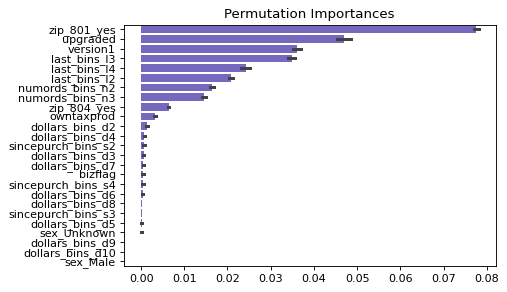

In [52]:
fig = importance(clf_cv, evar, intuit75k.res1_yes, evar.columns)

In [76]:
dct = {
    "training": eval_dat[eval_dat.training == 1],
    "test": eval_dat[eval_dat.training == 0]
}


In [77]:
rsm.evalbin(dct, 'res1_yes', 1, ['y_lr', 'y_lr_int', 'y_nn_cv'], cost=1.41, margin=60)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_lr,2184,27921,22081,314,52500,0.874,0.442,0.073,0.134,0.462,0.051,88591.95,1.000,2.087,0.573,0.776
1,training,y_lr_int,2184,27921,22081,314,52500,0.874,0.442,0.073,0.134,0.462,0.051,88591.95,1.000,2.087,0.573,0.776
2,training,y_nn_cv,2134,26275,23727,364,52500,0.854,0.475,0.075,0.138,0.493,0.055,87983.31,0.993,2.196,0.541,0.775
3,test,y_lr,937,12035,9362,166,22500,0.850,0.438,0.072,0.133,0.458,0.047,37929.48,1.000,2.074,0.577,0.764
4,test,y_lr_int,937,12035,9362,166,22500,0.850,0.438,0.072,0.133,0.458,0.047,37929.48,1.000,2.074,0.577,0.764
5,test,y_nn_cv,917,11315,10082,186,22500,0.831,0.471,0.075,0.138,0.489,0.052,37772.88,0.996,2.190,0.544,0.762


<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative gains'>

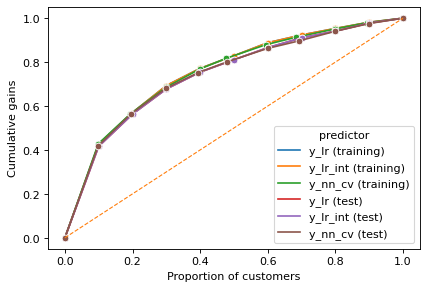

In [78]:
rsm.gains_plot(
        df=dct,
        rvar='res1_yes',
        lev=1,
        pred=['y_lr', 'y_lr_int', 'y_nn_cv'],
        qnt=10,
        marker='o',
    )

In [89]:
# profit calculator function
    
def profit_ids(model, data):


    brk_even_rate = 1.41 / 60

    data = data.assign(res2_pred=model)

    data = data.assign(
        res2_pred_yes=rsm.ifelse(data['res2_pred'] * 0.5 > brk_even_rate, 1, 0)
    )


    test = data.copy()
    
    test = test.query('training == 0')

    proj_profit_no_targeting = (
        0.5 * np.nanmean(test.res1_yes == 1) * (801821 - 38487) * 60
        - (801821 - 38487) * 1.41
    )

    proj_revenue_targeted = (
        0.5
        * np.nanmean(test.query('res2_pred_yes == 1').res1_yes == 1)
        * np.nanmean(test.res2_pred_yes == 1)
        * (801821 - 38487)
        * 60
    )
    proj_cost_targeted = np.nanmean(test.res2_pred_yes == 1) * (801821 - 38487) * 1.41
    proj_profit_targeted = proj_revenue_targeted - proj_cost_targeted
    
    # people who already responded (res1_yes == 1), do not get mailed again:
    
    mail_to = []
    for row in data.index:
        if data.res1_yes[row] == 0 and data.res2_pred_yes[row] == 1:
            mail_to = np.append(mail_to, 1)
        else:
            mail_to = np.append(mail_to, 0)

    test['mail_to'] = mail_to.astype('bool')

    target_ids = test.query('training == 0')[['id', 'mail_to']]

    target_ids = target_ids.rename(columns={'mail_to': 'mailto_wave2'})

    target_ids = target_ids.set_index('id', drop=True)

    return proj_profit_no_targeting, proj_profit_targeted, target_ids

In [90]:
model = eval_dat.y_nn_cv
data = intuit75k.query('training == 0')

proj_profit_no_targeting, proj_profit_targeted, target_ids = profit_ids(
    model, data
)

print("Wave 2_Projected profit_no_targeting: $", round(proj_profit_no_targeting, 2))
print("Wave 2_Projected profit_targeting using model: $", round(proj_profit_targeted, 2))
print("Customer IDs to target among the 22500: \n", target_ids)

Wave 2_Projected profit_no_targeting: $ 46308.93
Wave 2_Projected profit_targeting using model: $ 443420.72
IDs to target among the 22500: 
        mailto_wave2
id                 
2             False
3              True
5             False
7             False
9             False
...             ...
74982         False
74983         False
74988          True
74994         False
75000          True

[22500 rows x 1 columns]


In [ ]:
# saving target ids
# target_ids.to_csv(target_ids.csv)